In [1]:
#import twitter crawler
import snscrape.modules.twitter as sntwitter
import pandas as pd
import pandas as pd
import numpy as np
import json
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /Users/clara/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/clara/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Setting variables to be used below
maxTweets = 300

# Creating list to append tweet data to
tweets_list = []

keyword = "claimswap"

i = 0
# Using TwitterSearchScraper to scrape data and append tweets to list
for index,tweet in enumerate(sntwitter.TwitterSearchScraper(f'{keyword} since:2022-01-01 until:2022-12-31').get_items()):
#     if i>maxTweets:
#         break
    if keyword not in tweet.rawContent:
        continue
    if i > maxTweets:
        break
    i += 1
    tweets_list.append({
        "date": tweet.date,
        "tweet_id": tweet.id,
        "content": tweet.rawContent,
        "user_name": tweet.user.username
    })

In [113]:
# Creating a dataframe from the tweets list above
tweets_df = pd.DataFrame(tweets_list)
# Display first 5 entries from dataframe
tweets_df.head()

,date,tweet_id,content,user_name
0,2022-12-27 04:01:10+00:00,1607587365043998721,Топ проектов на @klaytn_official по объёму за ...,fiatisbubble
1,2022-12-27 04:00:45+00:00,1607587261620813824,Top Projects on @klaytn_official by 24H Volume...,FiatBubble
2,2022-12-03 04:31:27+00:00,1598897681170305025,@CryptoRubic @klaytn_official @claimswap go on,shiyi39711639
3,2022-12-02 17:15:45+00:00,1598727634493800448,@CryptoRubic @klaytn_official @claimswap Good ...,DecJ2523
4,2022-12-02 16:15:24+00:00,1598712445027160068,With the multiple @klaytn_official ecosystem p...,CryptoRubic


In [114]:
tweets_df.count()

date         293
tweet_id     293
content      293
user_name    293
dtype: int64

### Preparing steps
1. remove all non-english tweet
2. remove linka
3. seperate tags => count tags
4. seperate mentions => count mentions
5. seperate texts
6. Remove stop words
7. Lemmanate texts
8. sentiment on texts
9. word cloud

In [ ]:
# #join back text in text collumns
# tweets_df['rejoin_text'] = tweets_df['text'].str.join(" ")

In [12]:
# detect language #difficult to use
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)
text = 'This is an english text.'
doc = nlp(text)
print(doc._.language)

{'language': 'en', 'score': 0.9999961933392498}


In [13]:
text_ru = '@defillama @claimswap @klaytn_official 🤙哈哈哈！学习了'
doc_ru = nlp (text_ru)
doc_ru._.language

{'language': 'en', 'score': 0.8571415514892163}

In [115]:
langs = []
scores = []
for i in range(len(tweets_df)):
    text = tweets_df['content'].values[i]
    doc = nlp(text)
    lang = doc._.language.get('language')
    score = doc._.language.get('score')
    langs.append(lang)
    scores.append(score)

In [116]:
tweets_df['language'] = langs
tweets_df['score'] = scores
tweets_df.head()

,date,tweet_id,content,user_name,language,score
0,2022-12-27 04:01:10+00:00,1607587365043998721,Топ проектов на @klaytn_official по объёму за ...,fiatisbubble,en,0.857138
1,2022-12-27 04:00:45+00:00,1607587261620813824,Top Projects on @klaytn_official by 24H Volume...,FiatBubble,en,0.999998
2,2022-12-03 04:31:27+00:00,1598897681170305025,@CryptoRubic @klaytn_official @claimswap go on,shiyi39711639,en,0.999997
3,2022-12-02 17:15:45+00:00,1598727634493800448,@CryptoRubic @klaytn_official @claimswap Good ...,DecJ2523,en,0.999995
4,2022-12-02 16:15:24+00:00,1598712445027160068,With the multiple @klaytn_official ecosystem p...,CryptoRubic,en,0.999997


In [16]:
tweets_df['score'].describe()

count    293.000000
mean       0.914593
std        0.167468
min        0.285714
25%        0.857141
50%        0.999996
75%        0.999997
max        1.000000
Name: score, dtype: float64

In [ ]:
# #lang detect is much more simple to use
# from langdetect import detect
# #language detection only work with string
# langdet = []                                                    
# for i in range(len(tweets_df)):                                         
#     try:
#         lang=detect(tweets_df['content'][i])                                      
#     except:
#         lang='no'
#         lang='NaN'                
#     langdet.append(lang)
# tweets_df["lang"] = langdet

In [117]:
tweets_en = tweets_df[(tweets_df['score']>0.857141) & (tweets_df['language']=='en')].copy()

In [118]:
## Text pre-processing

#lowcase all words
tweets_en['content'] = [i.lower() for i in tweets_en['content']]

#tokenize all word
tknzr = TweetTokenizer()
tweets_en['text'] = [tknzr.tokenize(t) for t in tweets_en['content']]

#seperate hashtag and mention
tweets_en['hashtag'] = tweets_en['content'].apply(lambda x: re.findall(r'#(\w+)', x))
tweets_en['mention'] = tweets_en['content'].apply(lambda x: re.findall(r'@(\w+)', x))

#remove number
tweets_en['text'] = tweets_en['content'].apply(lambda x: re.findall(r'[^a-zA-Z0-9]', x))
tweets_en['text'] = tweets_en['content'].astype(str).str.replace('\d+', '')

#remove link from tweets
tweets_en['text'] = tweets_en['text'].apply(lambda x: re.sub(r'http\S+', '', x))
tweets_en['text'] = tweets_en['text'].apply(lambda x: re.sub(r'https?://\S+', '', x))

# Using regex to get all the words in a tweet that are not @mention or #hashtag
tweets_en['text'] = tweets_en['text'].apply(lambda x: re.findall(r'(?<![#@])\b\w+\b', x))


/var/folders/gj/4l0y085529x1vdmxg_yh405c0000gp/T/ipykernel_25998/2353089659.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  tweets_en['text'] = tweets_en['content'].astype(str).str.replace('\d+', '')


In [143]:
tweets_en.head()

,date,tweet_id,content,user_name,language,score,text,hashtag,mention,prep_text,rejoin_text
1,2022-12-27 04:00:45+00:00,1607587261620813824,top projects on @klaytn_official by 24h volume...,FiatBubble,en,0.999998,"[top, projects, on, by, h, volume]","[bluewhale, klaytn, klay, defi, dex, nft, nfts...","[klaytn_official, kleva_protocol, klayswap, de...","[top, project, h, volume]",top project h volume
2,2022-12-03 04:31:27+00:00,1598897681170305025,@cryptorubic @klaytn_official @claimswap go on,shiyi39711639,en,0.999997,"[go, on]",[],"[cryptorubic, klaytn_official, claimswap]",[go],go
3,2022-12-02 17:15:45+00:00,1598727634493800448,@cryptorubic @klaytn_official @claimswap good ...,DecJ2523,en,0.999995,"[good, ama, to, joining]",[],"[cryptorubic, klaytn_official, claimswap]","[good, ama, joining]",good ama joining
4,2022-12-02 16:15:24+00:00,1598712445027160068,with the multiple @klaytn_official ecosystem p...,CryptoRubic,en,0.999997,"[with, the, multiple, ecosystem, participants,...","[onchain, crosschain, swaps, eth, bsc, polygon...","[klaytn_official, claimswap]","[multiple, ecosystem, participant, including, ...",multiple ecosystem participant including compl...
5,2022-10-15 11:05:08+00:00,1581239745635831811,@claimswap ..when @voltinuofficial listing⚡⚡🤔🤔,EDMAND112124,en,0.999997,"[when, listing]",[],"[claimswap, voltinuofficial]",[listing],listing


In [120]:
#remove stop words
stop_words = set(stopwords.words('english'))
tweets_en['prep_text'] = tweets_en['text'].apply(lambda x: [item for item in x if item not in stop_words])

In [121]:
#lemmatize words (convert word to its base form)
lemmatizer = WordNetLemmatizer()
tweets_en['prep_text'] = tweets_en['prep_text'].apply(lambda lst:[lemmatizer.lemmatize(word) for word in lst])

In [122]:
# Extracting only the Tweet text from the data frame
tweet_pool = tweets_en['prep_text'].str.join(" ")
Tweet_Texts = " ".join(tweet_pool)
Tweet_Texts

'top project h volume go good ama joining multiple ecosystem participant including complete amp mai qi amp wemix supported network amp listing tracking volume dashboard price jump last min compared usdt trd gt claimswap gt lovedeesse gt price jump last min compared usdt claimswap gt ubsn gt hapy gt congratulation partnership make productive effect underlined task helping klaytn ecosystem grow matter project involved one clearly see partnership gonna one divine adventure congratulation team great partnership congratulation hope see greater thing manifest partnership hpe outcome positive great move expect see massive result yield wow good move hope brings growth congratulation new partnership hope brings desired result team thanks km claimswap collaboration optimistic better experience amazing collaboration congratulation congratulation congratulation congratulation pray positive outcome congratulation hope partnership help achieve community goal wow amazing partnership bring organic mem

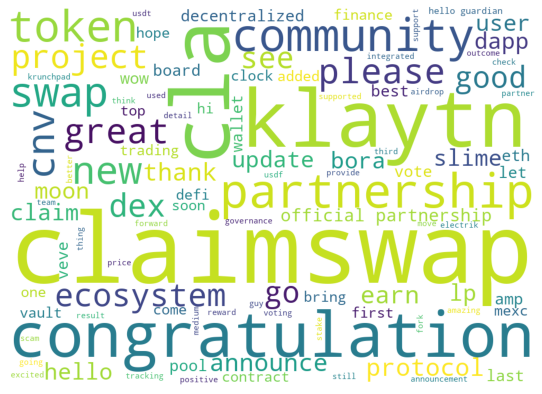

In [147]:
# Plotting the wordcloud 
# you can specify fonts, stopwords, background color and other options
import matplotlib.pyplot as plt
 
from wordcloud import WordCloud, STOPWORDS
# Creating the custom stopwords
customStopwords=list(STOPWORDS)+ ['http','co','gt','i','jm','x']
 
wordcloudimage = WordCloud(
                          max_words=100,
                          max_font_size=500,
                          font_step=2,
                          stopwords=customStopwords,
                          background_color='white',
                          width=1000,
                          height=720
                          ).generate(Tweet_Texts)
 
plt.figure(figsize=(15,7))
plt.axis("off")
plt.imshow(wordcloudimage)
wordcloudimage
plt.show()

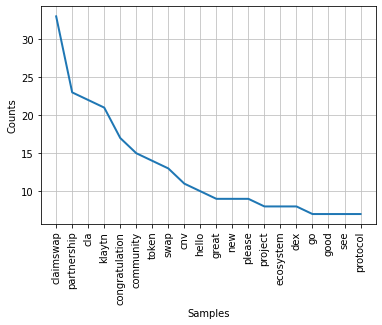

In [124]:
#create tweet frequency list
tweet_tokens = re.findall('\w+', Tweet_Texts)
nlp_words=nltk.FreqDist(tweet_tokens)
nlp_words.plot(20)
plt.show()

In [140]:
claimswap_nlp_words_freq = pd.DataFrame(nlp_words.items(), columns=['word', 'frequency'])
claimswap_nlp_words_freq

,word,frequency
0,top,4
1,project,8
2,h,1
3,volume,2
4,go,7
...,...,...
646,coming,1
647,looking,1
648,aware,1
649,meeting,1


## Sentiment Analysis

In [125]:
#import sentiment analysis tool
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#define sentiment_vader fuction: calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return {"neg": sentiment_dict['neg'],
            "neu": sentiment_dict['neu'],
            "pos": sentiment_dict['pos'],
            "com": sentiment_dict['compound'],
            "sentiment":overall_sentiment}

In [158]:
sentiment_vader('ijm coin is a klaytn based meme token we have')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'com': 0.0, 'sentiment': 'Neutral'}

In [148]:
tweets_en['rejoin_text'] = tweets_en['prep_text'].str.join(" ")

In [149]:
#sentiment works betters when text are in stings not seperate words
seme = []
for i in range(len(tweets_en)):
    sentiment = sentiment_vader(tweets_en["rejoin_text"].values[i])
    negative = sentiment["neg"]
    neutral = sentiment["neu"]
    positive = sentiment["pos"]
    overall_score = sentiment["com"]
    sentiment = sentiment["sentiment"]
    seme.append({'negative': negative,
                'neutral': neutral,
                'positive': positive,
                'overall_score': overall_score,
                'sentiment': sentiment})

In [150]:
seme = pd.DataFrame(seme)

In [151]:
tweet_seme = pd.concat([tweets_en, seme], axis=1)

In [152]:
tweet_seme

,date,tweet_id,content,user_name,language,score,text,hashtag,mention,prep_text,rejoin_text,negative,neutral,positive,overall_score,sentiment
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.735,0.265,0.2023,Positive
1,2022-12-27 04:00:45+00:00,1.607587e+18,top projects on @klaytn_official by 24h volume...,FiatBubble,en,0.999998,"[top, projects, on, by, h, volume]","[bluewhale, klaytn, klay, defi, dex, nft, nfts...","[klaytn_official, kleva_protocol, klayswap, de...","[top, project, h, volume]",top projects on by h volume,0.0,1.000,0.000,0.0000,Neutral
2,2022-12-03 04:31:27+00:00,1.598898e+18,@cryptorubic @klaytn_official @claimswap go on,shiyi39711639,en,0.999997,"[go, on]",[],"[cryptorubic, klaytn_official, claimswap]",[go],go on,0.0,0.508,0.492,0.4404,Positive
3,2022-12-02 17:15:45+00:00,1.598728e+18,@cryptorubic @klaytn_official @claimswap good ...,DecJ2523,en,0.999995,"[good, ama, to, joining]",[],"[cryptorubic, klaytn_official, claimswap]","[good, ama, joining]",good ama to joining,0.0,0.901,0.099,0.3182,Positive
4,2022-12-02 16:15:24+00:00,1.598712e+18,with the multiple @klaytn_official ecosystem p...,CryptoRubic,en,0.999997,"[with, the, multiple, ecosystem, participants,...","[onchain, crosschain, swaps, eth, bsc, polygon...","[klaytn_official, claimswap]","[multiple, ecosystem, participant, including, ...",with the multiple ecosystem participants inclu...,0.0,1.000,0.000,0.0000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2022-01-01 07:10:06+00:00,1.477175e+18,@tteokmill @klayswap @claimswap @dsc_hanul it'...,DAO_ChoCo,en,0.999996,"[it, s, still, just, an, imagination, but, i, ...",[],"[tteokmill, klayswap, claimswap, dsc_hanul]","[still, imagination, think, would, really, coo...",it s still just an imagination but i think it ...,NaN,NaN,NaN,NaN,NaN
289,2022-01-01 07:06:46+00:00,1.477174e+18,$ijm coin is a klaytn-based meme token. we ha...,DAO_ChoCo,en,0.999996,"[ijm, coin, is, a, klaytn, based, meme, token,...",[밈코인_인절미],"[tteokmill, klayswap, claimswap, dsc_hanul]","[ijm, coin, klaytn, based, meme, token, hard, ...",ijm coin is a klaytn based meme token we have ...,NaN,NaN,NaN,NaN,NaN
290,2022-01-01 06:43:44+00:00,1.477169e+18,@claimswap @klaytn_official happy new year~,KevinKim7777,en,0.999999,"[happy, new, year]",[],"[claimswap, klaytn_official]","[happy, new, year]",happy new year,NaN,NaN,NaN,NaN,NaN
291,2022-01-01 06:28:08+00:00,1.477165e+18,@claimswap @turutu_of_cla @sushiswap @jkpark03...,kangmurphy,en,0.857142,[],[],"[claimswap, turutu_of_cla, sushiswap, jkpark03...",[],,NaN,NaN,NaN,NaN,NaN


In [153]:
seme_df = pd.DataFrame(tweet_seme['sentiment'].value_counts())

<BarContainer object of 3 artists>

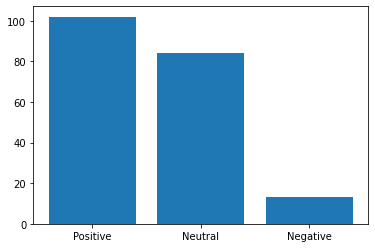

In [154]:
plt.bar(seme_df.index, seme_df.sentiment)

In [141]:
claimswap_nlp_words_freq.to_csv('claimswap_nlp_words_freq.csv')

In [155]:
seme_final = tweet_seme[['tweet_id','negative','neutral','positive','overall_score','sentiment']].copy()
seme_final.dropna(inplace = True)

In [156]:
seme_final['overall_score'].describe()

count    143.000000
mean       0.319754
std        0.363588
min       -0.648600
25%        0.000000
50%        0.296000
75%        0.624900
max        0.924600
Name: overall_score, dtype: float64

In [108]:
seme_final.to_csv('claimswap_seme_final.csv')